In [96]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import os, pickle
from collections import defaultdict, OrderedDict

import numpy as np
import keras.backend as K

import kde
import simplebinmi

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')

import utils

# load data network was trained on
trn, tst = utils.get_IB_data('2017_12_21_16_51_3_275766')
# trn, tst = utils.get_mnist()

# calc MI for train and test. Save_activations must have been run with cfg['FULL_MI'] = True
FULL_MI = True

# Which measure to plot
infoplane_measure = 'upper'
# infoplane_measure = 'bin'

DO_SAVE        = True    # Whether to save plots or just show them
DO_LOWER       = (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = (infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 10000      # Max number of epoch for which to compute mutual information measure
NUM_LABELS = 2
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 10000

# Directories from which to load saved layer activity
# ARCH = '1024-20-20-20'
ARCH = '10-7-5-4-3'
#ARCH = '20-20-20-20-20-20'
#ARCH = '32-28-24-20-16-12'
#ARCH = '32-28-24-20-16-12-8-8'
DIR_TEMPLATE = '%%s_%s'%ARCH

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-3                    # Added Gaussian noise variance
binsize = 0.07                           # size of bins for binning method
Klayer_activity = K.placeholder(ndim=2)  # Keras placeholder 
entropy_func_upper = K.function([Klayer_activity,], [kde.entropy_estimator_kl(Klayer_activity, noise_variance),])
entropy_func_lower = K.function([Klayer_activity,], [kde.entropy_estimator_bd(Klayer_activity, noise_variance),])

# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 

# Save indexes of tests data for each of the output classes
saved_labelixs = {}

y = tst.y
Y = tst.Y
if FULL_MI:
    full = utils.construct_full_dataset(trn,tst)
    y = full.y
    Y = full.Y

for i in range(NUM_LABELS):
    saved_labelixs[i] = y == i

labelprobs = np.mean(Y, axis=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
measures = OrderedDict()
# measures['tanh'] = {}
measures['relu'] = {}
# measures['softsign'] = {}
# measures['softplus'] = {}

Compute MI measures
-----

In [98]:
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    print(sorted(os.listdir(cur_dir)))
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        fname = cur_dir + "/" + epochfile
        with open(fname, 'rb') as f:
            d = pickle.load(f)

        epoch = d['epoch']
        if epoch in measures[activation]: # Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d['data']['activity_tst'])

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d['data']['activity_tst'][lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper([activity,])[0]
            if DO_LOWER:
                h_lower = entropy_func_lower([activity,])[0]
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(NUM_LABELS):
                hcond_upper = entropy_func_upper([activity[saved_labelixs[i],:],])[0]
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(NUM_LABELS):
                    hcond_lower = entropy_func_lower([activity[saved_labelixs[i],:],])[0]
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binned estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, binsize)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
                        
            print('- Layer %d %s' % (lndx, pstr) )

        measures[activation][epoch] = cepochdata

*** Doing rawdata/relu_10-7-5-4-3 ***
['epoch00000000', 'epoch00000001', 'epoch00000002', 'epoch00000003', 'epoch00000004', 'epoch00000005', 'epoch00000006', 'epoch00000007', 'epoch00000008', 'epoch00000009', 'epoch00000010', 'epoch00000011', 'epoch00000012', 'epoch00000013', 'epoch00000014', 'epoch00000015', 'epoch00000016', 'epoch00000017', 'epoch00000018', 'epoch00000019', 'epoch00000020', 'epoch00000025', 'epoch00000030', 'epoch00000035', 'epoch00000040', 'epoch00000045', 'epoch00000050', 'epoch00000055', 'epoch00000060', 'epoch00000065', 'epoch00000070', 'epoch00000075', 'epoch00000080', 'epoch00000085', 'epoch00000090', 'epoch00000095', 'epoch00000100', 'epoch00000120', 'epoch00000140', 'epoch00000160', 'epoch00000180', 'epoch00000200', 'epoch00000220', 'epoch00000240', 'epoch00000260', 'epoch00000280', 'epoch00000300', 'epoch00000320', 'epoch00000340', 'epoch00000360', 'epoch00000380', 'epoch00000400', 'epoch00000420', 'epoch00000440', 'epoch00000460', 'epoch00000480', 'epoch000

- Layer 1 upper: MI(X;M)=10.872, MI(Y;M)=0.716
- Layer 2 upper: MI(X;M)=8.231, MI(Y;M)=0.400
- Layer 3 upper: MI(X;M)=5.350, MI(Y;M)=0.286
- Layer 4 upper: MI(X;M)=4.255, MI(Y;M)=0.272
- Layer 5 upper: MI(X;M)=2.282, MI(Y;M)=0.199
Doing rawdata/relu_10-7-5-4-3/epoch00000016
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=10.874, MI(Y;M)=0.716
- Layer 2 upper: MI(X;M)=8.227, MI(Y;M)=0.399
- Layer 3 upper: MI(X;M)=5.345, MI(Y;M)=0.286
- Layer 4 upper: MI(X;M)=4.249, MI(Y;M)=0.272
- Layer 5 upper: MI(X;M)=2.278, MI(Y;M)=0.198
Doing rawdata/relu_10-7-5-4-3/epoch00000017
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=10.876, MI(Y;M)=0.716
- Layer 2 upper: MI(X;M)=8.225, MI(Y;M)=0.398
- Layer 3 upper: MI(X;M)=5.340, MI(Y;M)=0.285
- Layer 4 upper: MI(X;M)=4.244, MI(Y;M)=0.271
- Layer 5 upper: MI(X;M)=2.274, MI(Y;M)=0.197
Doing rawdata/relu_10-7-5-4-3/epoch00000018
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=10.877, M

- Layer 5 upper: MI(X;M)=1.316, MI(Y;M)=0.068
Doing rawdata/relu_10-7-5-4-3/epoch00000200
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.242, MI(Y;M)=0.775
- Layer 2 upper: MI(X;M)=7.771, MI(Y;M)=0.280
- Layer 3 upper: MI(X;M)=4.198, MI(Y;M)=0.179
- Layer 4 upper: MI(X;M)=3.156, MI(Y;M)=0.164
- Layer 5 upper: MI(X;M)=1.185, MI(Y;M)=0.052
Doing rawdata/relu_10-7-5-4-3/epoch00000220
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.285, MI(Y;M)=0.784
- Layer 2 upper: MI(X;M)=7.774, MI(Y;M)=0.277
- Layer 3 upper: MI(X;M)=4.082, MI(Y;M)=0.170
- Layer 4 upper: MI(X;M)=3.053, MI(Y;M)=0.154
- Layer 5 upper: MI(X;M)=1.060, MI(Y;M)=0.037
Doing rawdata/relu_10-7-5-4-3/epoch00000240
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.327, MI(Y;M)=0.794
- Layer 2 upper: MI(X;M)=7.783, MI(Y;M)=0.276
- Layer 3 upper: MI(X;M)=3.978, MI(Y;M)=0.162
- Layer 4 upper: MI(X;M)=2.958, MI(Y;M)=0.147
- Layer 5 upper: MI(X;M)=0.948, MI

- Layer 2 upper: MI(X;M)=9.459, MI(Y;M)=0.495
- Layer 3 upper: MI(X;M)=4.629, MI(Y;M)=0.233
- Layer 4 upper: MI(X;M)=3.855, MI(Y;M)=0.210
- Layer 5 upper: MI(X;M)=1.837, MI(Y;M)=0.124
Doing rawdata/relu_10-7-5-4-3/epoch00000720
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.640, MI(Y;M)=0.884
- Layer 2 upper: MI(X;M)=9.520, MI(Y;M)=0.507
- Layer 3 upper: MI(X;M)=4.716, MI(Y;M)=0.241
- Layer 4 upper: MI(X;M)=3.950, MI(Y;M)=0.218
- Layer 5 upper: MI(X;M)=1.898, MI(Y;M)=0.130
Doing rawdata/relu_10-7-5-4-3/epoch00000740
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.651, MI(Y;M)=0.888
- Layer 2 upper: MI(X;M)=9.580, MI(Y;M)=0.518
- Layer 3 upper: MI(X;M)=4.805, MI(Y;M)=0.250
- Layer 4 upper: MI(X;M)=4.047, MI(Y;M)=0.227
- Layer 5 upper: MI(X;M)=1.959, MI(Y;M)=0.137
Doing rawdata/relu_10-7-5-4-3/epoch00000760
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.663, MI(Y;M)=0.892
- Layer 2 upper: MI(X;M)=9.643, MI

- Layer 5 upper: MI(X;M)=3.222, MI(Y;M)=0.351
Doing rawdata/relu_10-7-5-4-3/epoch00001220
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.862, MI(Y;M)=0.952
- Layer 2 upper: MI(X;M)=10.578, MI(Y;M)=0.712
- Layer 3 upper: MI(X;M)=6.389, MI(Y;M)=0.432
- Layer 4 upper: MI(X;M)=6.014, MI(Y;M)=0.426
- Layer 5 upper: MI(X;M)=3.264, MI(Y;M)=0.360
Doing rawdata/relu_10-7-5-4-3/epoch00001240
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.869, MI(Y;M)=0.955
- Layer 2 upper: MI(X;M)=10.610, MI(Y;M)=0.719
- Layer 3 upper: MI(X;M)=6.441, MI(Y;M)=0.439
- Layer 4 upper: MI(X;M)=6.074, MI(Y;M)=0.434
- Layer 5 upper: MI(X;M)=3.305, MI(Y;M)=0.369
Doing rawdata/relu_10-7-5-4-3/epoch00001260
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.874, MI(Y;M)=0.956
- Layer 2 upper: MI(X;M)=10.640, MI(Y;M)=0.726
- Layer 3 upper: MI(X;M)=6.489, MI(Y;M)=0.445
- Layer 4 upper: MI(X;M)=6.128, MI(Y;M)=0.440
- Layer 5 upper: MI(X;M)=3.344,

- Layer 1 upper: MI(X;M)=11.970, MI(Y;M)=0.990
- Layer 2 upper: MI(X;M)=11.267, MI(Y;M)=0.865
- Layer 3 upper: MI(X;M)=7.734, MI(Y;M)=0.575
- Layer 4 upper: MI(X;M)=7.482, MI(Y;M)=0.570
- Layer 5 upper: MI(X;M)=3.965, MI(Y;M)=0.515
Doing rawdata/relu_10-7-5-4-3/epoch00001740
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.972, MI(Y;M)=0.991
- Layer 2 upper: MI(X;M)=11.285, MI(Y;M)=0.869
- Layer 3 upper: MI(X;M)=7.786, MI(Y;M)=0.581
- Layer 4 upper: MI(X;M)=7.538, MI(Y;M)=0.576
- Layer 5 upper: MI(X;M)=3.976, MI(Y;M)=0.520
Doing rawdata/relu_10-7-5-4-3/epoch00001760
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.973, MI(Y;M)=0.991
- Layer 2 upper: MI(X;M)=11.304, MI(Y;M)=0.874
- Layer 3 upper: MI(X;M)=7.836, MI(Y;M)=0.587
- Layer 4 upper: MI(X;M)=7.594, MI(Y;M)=0.581
- Layer 5 upper: MI(X;M)=3.987, MI(Y;M)=0.524
Doing rawdata/relu_10-7-5-4-3/epoch00001780
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.975

- Layer 4 upper: MI(X;M)=9.322, MI(Y;M)=0.739
- Layer 5 upper: MI(X;M)=3.586, MI(Y;M)=0.650
Doing rawdata/relu_10-7-5-4-3/epoch00003200
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.997, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=11.768, MI(Y;M)=0.966
- Layer 3 upper: MI(X;M)=9.340, MI(Y;M)=0.739
- Layer 4 upper: MI(X;M)=9.358, MI(Y;M)=0.747
- Layer 5 upper: MI(X;M)=3.560, MI(Y;M)=0.654
Doing rawdata/relu_10-7-5-4-3/epoch00003300
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.997, MI(Y;M)=0.998
- Layer 2 upper: MI(X;M)=11.771, MI(Y;M)=0.967
- Layer 3 upper: MI(X;M)=9.362, MI(Y;M)=0.742
- Layer 4 upper: MI(X;M)=9.389, MI(Y;M)=0.750
- Layer 5 upper: MI(X;M)=3.537, MI(Y;M)=0.658
Doing rawdata/relu_10-7-5-4-3/epoch00003400
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.998, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.772, MI(Y;M)=0.968
- Layer 3 upper: MI(X;M)=9.384, MI(Y;M)=0.745
- Layer 4 upper: MI(X;M)=9.420,

- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.800, MI(Y;M)=0.976
- Layer 3 upper: MI(X;M)=9.660, MI(Y;M)=0.798
- Layer 4 upper: MI(X;M)=9.721, MI(Y;M)=0.811
- Layer 5 upper: MI(X;M)=3.237, MI(Y;M)=0.709
Doing rawdata/relu_10-7-5-4-3/epoch00005800
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.801, MI(Y;M)=0.976
- Layer 3 upper: MI(X;M)=9.669, MI(Y;M)=0.799
- Layer 4 upper: MI(X;M)=9.730, MI(Y;M)=0.811
- Layer 5 upper: MI(X;M)=3.229, MI(Y;M)=0.710
Doing rawdata/relu_10-7-5-4-3/epoch00005900
- Layer 0 upper: MI(X;M)=12.000, MI(Y;M)=0.999
- Layer 1 upper: MI(X;M)=11.999, MI(Y;M)=0.999
- Layer 2 upper: MI(X;M)=11.803, MI(Y;M)=0.976
- Layer 3 upper: MI(X;M)=9.677, MI(Y;M)=0.799
- Layer 4 upper: MI(X;M)=9.740, MI(Y;M)=0.811
- Layer 5 upper: MI(X;M)=3.221, MI(Y;M)=0.711
Doing rawdata/relu_10-7-5-4-3/epoch00006000
- Layer 0 upper: MI(X;M)=12.000

Plot Infoplane Visualization
----

/Users/xyli1905/anaconda3/envs/keras_p37/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


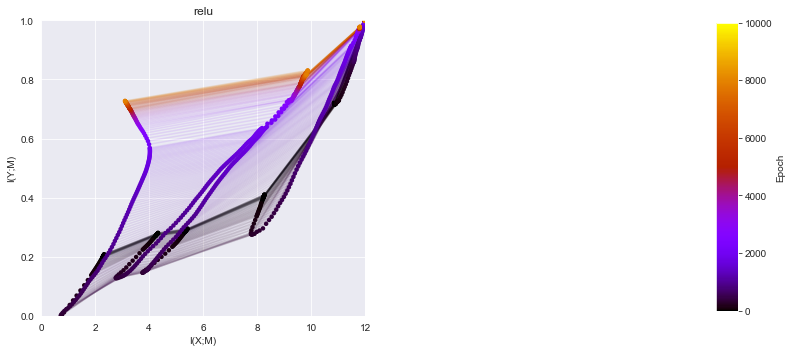

In [99]:
max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

fig=plt.figure(figsize=(10,5))
for actndx, (activation, vals) in enumerate(measures.items()):
    epochs = sorted(vals.keys())
    if not len(epochs):
        continue
    plt.subplot(1,2,actndx+1)    
    for epoch in epochs:
        c = sm.to_rgba(epoch)
        xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
        ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

        plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
        plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)

    plt.ylim([0, 1])
    plt.xlim([0, 12])
#     plt.ylim([0, 3.5])
#     plt.xlim([0, 14])
    plt.xlabel('I(X;M)')
    plt.ylabel('I(Y;M)')
    plt.title(activation)
    
cbaxes = fig.add_axes([1.0, 0.125, 0.03
                       , 0.8]) 
plt.colorbar(sm, label='Epoch', cax=cbaxes)
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')

Plot SNR curves
----

/Users/xyli1905/anaconda3/envs/keras_p37/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


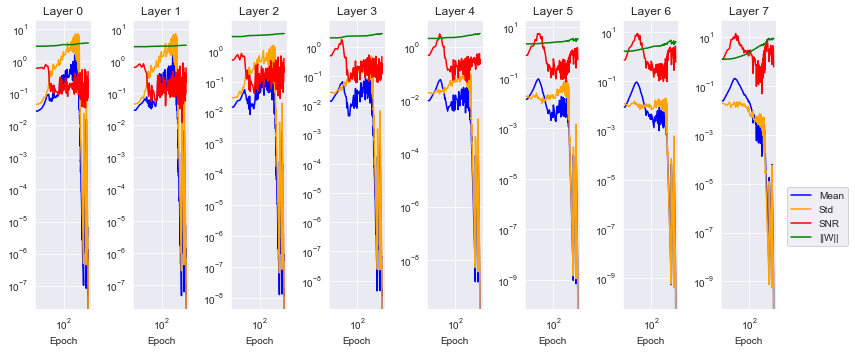

In [43]:
plt.figure(figsize=(12,5))

gs = gridspec.GridSpec(len(measures), len(PLOT_LAYERS))
for activation in measures.keys():
    cur_dir = 'rawdata/' + DIR_TEMPLATE % activation
    if not os.path.exists(cur_dir):
        continue
        
    epochs = []
    means = []
    stds = []
    wnorms = []
    for epochfile in sorted(os.listdir(cur_dir)):
        if not epochfile.startswith('epoch'):
            continue
            
        with open(cur_dir + "/"+epochfile, 'rb') as f:
            d = pickle.load(f)
            
        epoch = d['epoch']
        epochs.append(epoch)
        wnorms.append(d['data']['weights_norm'])
        means.append(d['data']['gradmean'])
        stds.append(d['data']['gradstd'])

    wnorms, means, stds = map(np.array, [wnorms, means, stds])
    for lndx,layerid in enumerate(PLOT_LAYERS):
        plt.subplot(gs[actndx, lndx])
        plt.plot(epochs, means[:,layerid], 'b', label="Mean")
        plt.plot(epochs, stds[:,layerid], 'orange', label="Std")
        plt.plot(epochs, means[:,layerid]/stds[:,layerid], 'red', label="SNR")
        plt.plot(epochs, wnorms[:,layerid], 'g', label="||W||")

        plt.title('Layer %d'%layerid)
        plt.xlabel('Epoch')
        plt.gca().set_xscale("log", nonposx='clip')
        plt.gca().set_yscale("log", nonposy='clip')
    

plt.legend(loc='lower left', bbox_to_anchor=(1.1, 0.2))
plt.tight_layout()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('snr_'+ARCH), bbox_inches='tight')


In [94]:
x = np.array([[1,2],[3,4],[5,6]])

In [95]:
len(x)

3